In [1]:
# Load the Packages

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

2023-06-24 14:51:38.131883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Evaluating a Learning Algorithm (Polynomial Regression)

Let's say you have created a machine learning model and you find it *fits* your training data very well. You're done? Not quite. The goal of creating the model was to be able to predict values for <span style="color:blue">*new* </span> examples. 

How can you test your model's performance on new data before deploying it?   
The answer has two parts:
* Split your original data set into "Training" and "Test" sets. 
    * Use the training data to fit the parameters of the model
    * Use the test data to evaluate the model on *new* data
* Develop an error function to evaluate your model.
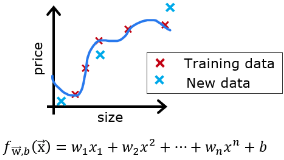

#### Split the Data Set
Lectures advised reserving 20-40% of your data set for testing. Let's use an `sklearn` function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform the split. Double-check the shapes after running the following cell.

In [2]:
# Generate Some Data

def gen_data(m, seed=1, scale=0.7):
    """ Generate a data set based on a x^2 with added noise. """
    c = 0
    x_train = np.linspace(0,49,m)
    np.random.seed(seed)
    y_ideal = x_train**2 + c
    y_train = y_ideal + scale * y_ideal*(np.random.sample((m,))-0.5)
    x_ideal = x_train # For Redraw When New Data Included in X
    return x_train, y_train, x_ideal, y_ideal

X, y, x_ideal, y_ideal = gen_data(18, 2, 0.7)
print("X.shape:", X.shape, "y.shape:", y.shape)

X.shape: (18,) y.shape: (18,)


In [3]:
# Split the Data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print("X_train.shape:", X_train.shape, "y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape, "y_test.shape:", y_test.shape)

X_train.shape: (12,) y_train.shape: (12,)
X_test.shape: (6,) y_test.shape: (6,)


#### Plot the Train and Test Sets
You can see below the data points that will be part of training (in red) are intermixed with those that the model is not trained on (test). This particular data set is a quadratic function with noise added. The "ideal" curve is shown for reference.

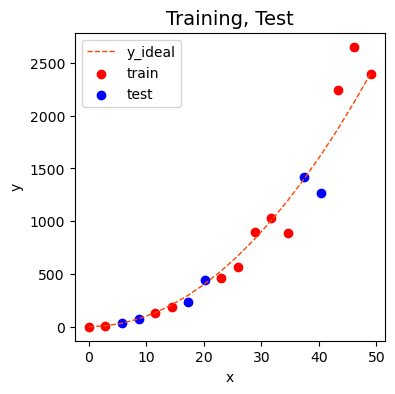

In [4]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red", label="train")
ax.scatter(X_test, y_test,   color = "blue", label="test")
ax.legend(loc='upper left')
plt.show()

### Error Calculation for Model Evaluation (Linear Regression)

When *evaluating* a linear regression model, you average the squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

In [5]:
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    err = 0
    m = len(y)
    
    for i in range(m):
        err += (yhat[i]-y[i])**2
    err /= 2*m
    
    return err    

### Evaluating Categorical Model  (Calculating Classification Error)
The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>

In [6]:
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:
            incorrect += 1
    
    cerr = incorrect/m    
    return(cerr)